In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import pdb
import glob
import itertools
from utils import constants as cnst
from wavelet import util, wav
from scipy.ndimage.measurements import label
from scipy import ndimage
from utils import u_arrays as ua, u_grid
import numpy.ma as ma
import pickle as pkl
from eod import mfg
from utils import u_grid, u_interpolate as u_int

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [4]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [6]:
msg_file = '/home/ck/DIR/cornkle/data/vera_test/cores_-40_700km2_-50points_dominant_2004_09.nc'
mfg_file = '/home/ck/DIR/cornkle/data/vera_test/cores_MFG_-40_700km2_-50points_dominant_2004_09.nc'

In [7]:
ar_msg = xr.open_dataset(msg_file)
ar_mfg = xr.open_dataset(mfg_file)

In [11]:
day=150
tmsg = ar_msg.isel(time=day)
tmfg = ar_mfg.isel(time=day)

tmsg['tir'].values = tmsg['tir']/100
tmfg['tir'].values = tmfg['tir']/100

tmsg['tir'].values[tmsg['tir']>=-10] = 0
tmfg['tir'].values[tmfg['tir']>=-10] = 0

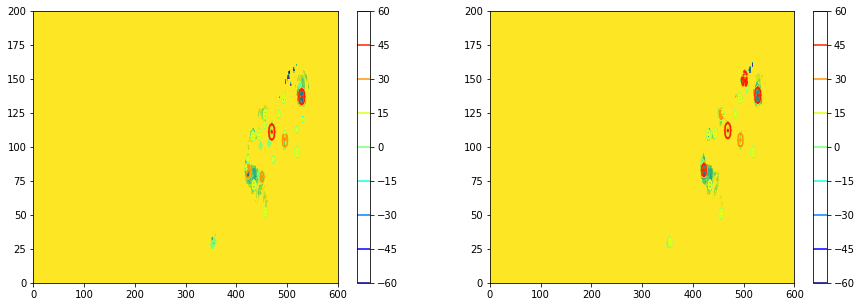

In [12]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

levels = np.linspace(-3,3,9) #MaxNLocator(nbins=15).tick_values(z.min(), z.max())

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

box = [100,250,160, 200]
box = [100,200,75,200]
#box = [100,200,400,550]
box = [50,250,0,600]


f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
plt.pcolormesh(tmsg['tir'][box[0]:box[1], box[2]:box[3]], vmax=-60)
plt.contour(tmsg['blobs'][box[0]:box[1], box[2]:box[3]], cmap='jet')
plt.colorbar()
ax = f.add_subplot(122)
plt.pcolormesh(tmfg['tir'][box[0]:box[1], box[2]:box[3]], vmax=-60)
plt.contour(tmfg['blobs'][box[0]:box[1], box[2]:box[3]], cmap='jet')
plt.colorbar()

In [17]:
msg_imgg = tmsg['tir'][box[0]:box[1], box[2]:box[3]]
mfg_imgg = tmfg['tir'][box[0]:box[1], box[2]:box[3]]

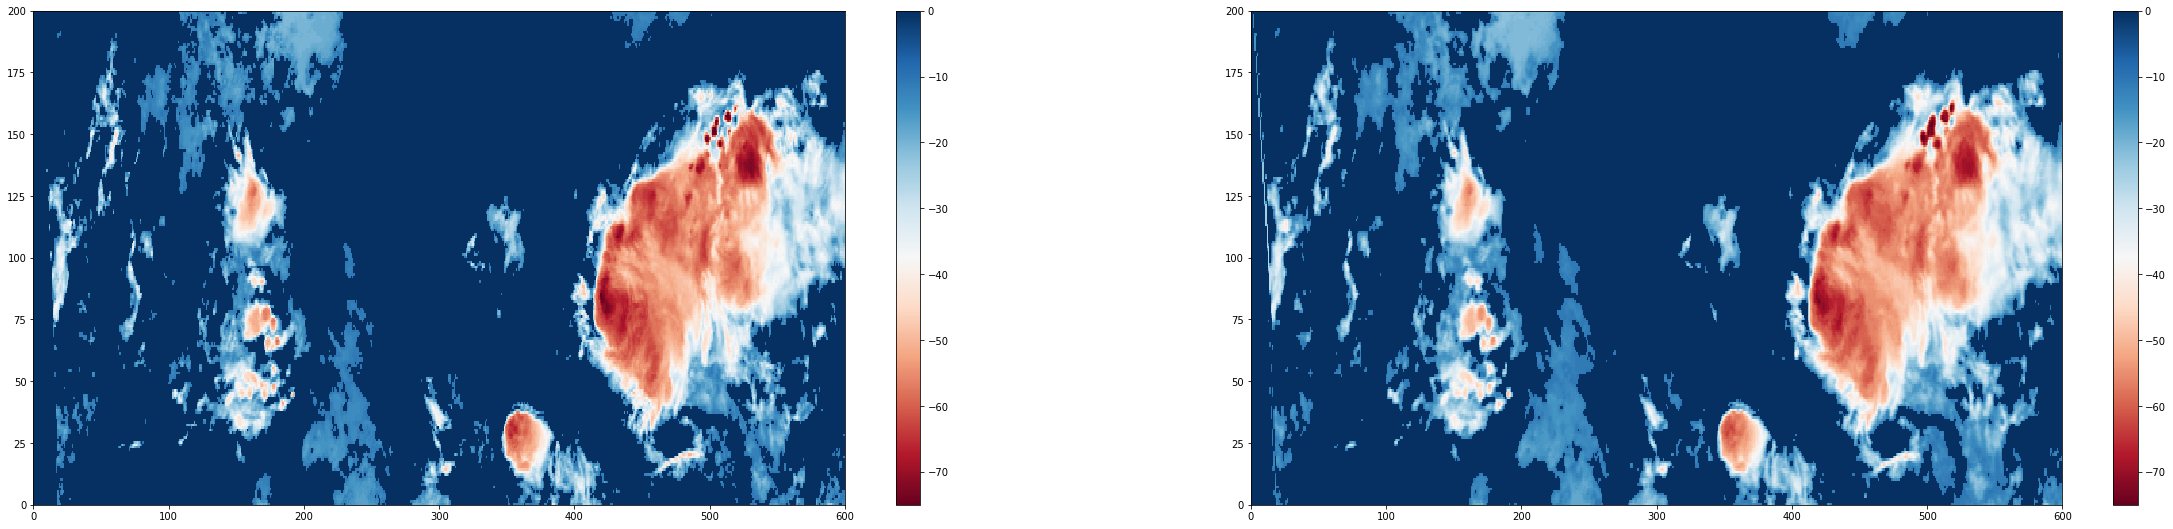

In [18]:
f = plt.figure(figsize=(40,20))
ax = f.add_subplot(221)
plt.pcolormesh(msg_imgg, cmap='RdBu', vmin=-75)
plt.colorbar()
ax = f.add_subplot(222)
plt.pcolormesh(mfg_imgg, cmap='RdBu', vmin=-75)
plt.colorbar()

In [19]:
def filter_img(inarr):
    
        outt = inarr.copy()
        print('outmin', np.nanmin(outt), np.nanmax(outt))
        
        t_thresh_size = -40
        t_thresh_cut = -50

        core_min = -50

        outt[outt>=t_thresh_size] = 0
        outt[np.isnan(outt)] = 0

        labels, numL = label(outt)

        u, inv = np.unique(labels, return_inverse=True)
        n = np.bincount(inv)

        pix_nb = 28

        badinds = u[(n < pix_nb)]  # all blobs with more than 1000 pixels = 25,000km2 (meteosat regridded 5km), 200pix = 5000km2, 8pix = 200km2
        # scale 30km, radius 15km ca. 700km2 circular area equals 28 pix

        for bi in badinds:
            inds = np.where(labels == bi)
            outt[inds] = 0

        outt[outt >=t_thresh_cut] = 150

        grad = np.gradient(outt)
        outt[outt == 150] = np.nan

        nogood = np.isnan(outt) # filters edge maxima later, no maxima in -40 edge area by definition!

        tdiff = np.nanmax(outt)-np.nanmin(outt) # define background temperature for image
        if tdiff > 28:  # temp difference of 28 degrees
            xmin = 15
        else:
            xmin = 10
        xmin=10
        outt[nogood] = t_thresh_cut-xmin
        nok = np.where(abs(grad[0]) > 80)
        d = 2
        i = nok[0]
        j = nok[1]
        # edge smoothing for wavelet application
        for ii, jj in zip(i, j):
            kern = outt[ii - d:ii + d + 1, jj - d:jj + d + 1]
            outt[ii - d:ii + d + 1, jj - d:jj + d + 1] = ndimage.gaussian_filter(kern, 3, mode='nearest')
        
        return outt, nogood

In [20]:
mfg_img, mfg_nogood = filter_img(mfg_imgg.values)
msg_img, msg_nogood = filter_img(msg_imgg.values)

outmin -76.85 0.0
outmin -78.91 0.0


In [21]:
mfg_pow = util.waveletT(mfg_img, dataset='METEOSAT5K_vera')
msg_pow = util.waveletT(msg_img, dataset='METEOSAT5K_vera')

In [22]:
mfg_pow['scales']

array([25.        , 35.35533906, 50.        ])

In [23]:
(mfg_pow['scales'])**.5

array([5.        , 5.94603558, 7.07106781])

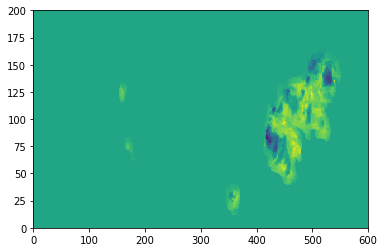

In [24]:
plt.pcolormesh(mfg_img)

In [25]:
def find_scales_dominant(wav, outt,core_min=None, no_good=None, dataset=None):
    outt[no_good] = np.nan

    arr = np.array(wav['scales'], dtype=str)

    wll = wav['t']
    
    power_img = np.sum(wll, axis=0)
    power_img[no_good] = 0
    
    
    if dataset == 'mfg':

        smaller = -17
        thresh_p = np.sum((wav['scales']+smaller)**.5)
        power_img[(power_img<np.percentile(power_img[power_img>1],25)) | (power_img < (thresh_p))]=0   
    if dataset == 'msg':

        smaller = -8
        thresh_p = np.sum((wav['scales']+smaller)**.5)
        power_img[(power_img<np.percentile(power_img[power_img>1],25)) | (power_img < (thresh_p))]=0 
        


    labels, numL = label(power_img)
    u, inv = np.unique(labels, return_inverse=True)
    
    for inds in u:
        if inds == 0:
            continue

        arr = power_img.copy()
        arr[np.where(labels!=inds)]=0
    
        power_img.flat[np.argmax(arr)] = -999
    

    return power_img

In [26]:
power_msg = find_scales_dominant(msg_pow, msg_img, no_good=msg_nogood, core_min=-50, dataset='msg')
power_mfg = find_scales_dominant(mfg_pow, mfg_img, no_good=mfg_nogood, core_min=-50, dataset='mfg')

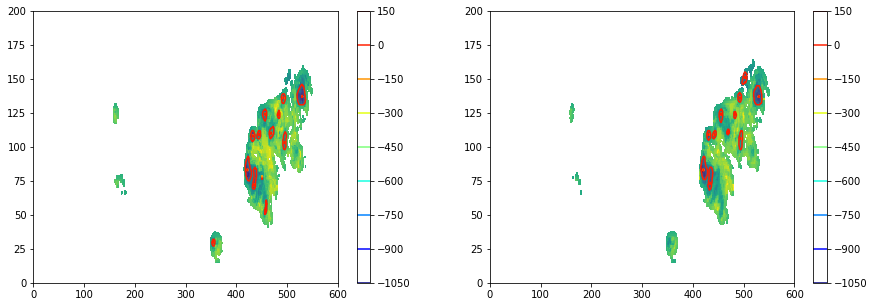

In [27]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

levels = np.linspace(-3,3,9) #MaxNLocator(nbins=15).tick_values(z.min(), z.max())

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)


f = plt.figure(figsize=(15,5))

ax = f.add_subplot(121)
plt.pcolormesh(msg_img)
plt.contour(power_msg, cmap='jet')
plt.colorbar()
ax = f.add_subplot(122)

plt.pcolormesh(mfg_img)
plt.contour(power_mfg, cmap='jet')
plt.colorbar()

In [28]:
(np.sum(power_msg>0)-np.sum(power_mfg>0))/np.sum(power_mfg>0)

0.0016313213703099511

In [29]:
np.sum(power_msg==-999)

13

In [30]:
np.sum(power_mfg==-999)

11

In [31]:
(np.sum(power_msg<-10)-np.sum(power_mfg<-10))/np.sum(power_mfg<-10)

0.18181818181818182

(array([214., 142.,  79.,  39.,  37.,  25.,  23.,  21.,  16.,  17.]),
 array([12.90886964, 19.74567239, 26.58247514, 33.4192779 , 40.25608065,
        47.0928834 , 53.92968615, 60.7664889 , 67.60329165, 74.4400944 ,
        81.27689715]),
 <a list of 10 Patch objects>)

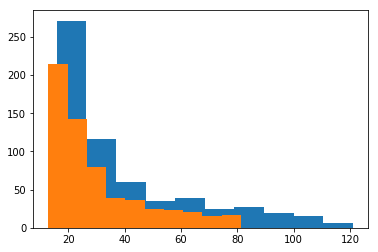

In [32]:
plt.hist(power_msg[power_msg>0.0001])
plt.hist(power_mfg[power_mfg>0.0001])

In [33]:
diff = (power_msg>0).astype(int)-(power_mfg>0).astype(int)

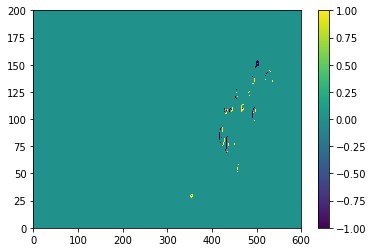

In [34]:
plt.pcolormesh(diff)
plt.colorbar()

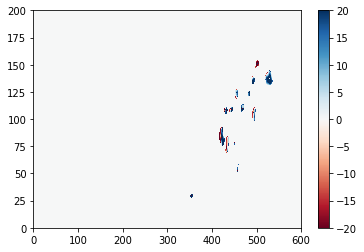

In [35]:
diff = (power_msg)-(power_mfg)
plt.pcolormesh(diff, cmap='RdBu', vmin=-20, vmax=20)
plt.colorbar()

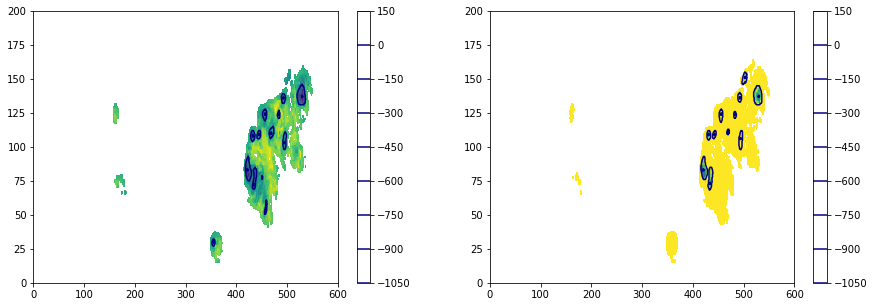

In [36]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

levels = np.linspace(-3,3,9) #MaxNLocator(nbins=15).tick_values(z.min(), z.max())

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)


f = plt.figure(figsize=(15,5))

ax = f.add_subplot(121)
plt.pcolormesh(msg_img)
plt.contour(power_msg, cmap='jet', vmin=0)
plt.colorbar()
ax = f.add_subplot(122)

plt.pcolormesh(mfg_img, vmax=-65)
plt.contour(power_mfg, cmap='jet', vmin=0)
plt.colorbar()

(array([  4.,  23.,  65.,  80., 113.,  94.,  55.,  71.,  89.,  20.]),
 array([-75.83 , -74.183, -72.536, -70.889, -69.242, -67.595, -65.948,
        -64.301, -62.654, -61.007, -59.36 ]),
 <a list of 10 Patch objects>)

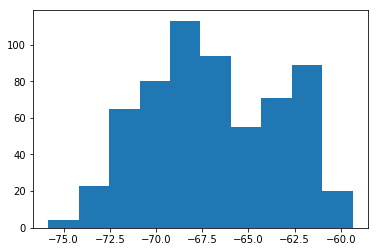

In [37]:
plt.hist(msg_img[power_msg>0])

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


(array([  2.,  24.,  52.,  86., 113., 130., 164., 316., 509., 637.]),
 array([-75.83      , -74.24700363, -72.66400725, -71.08101088,
        -69.49801451, -67.91501814, -66.33202176, -64.74902539,
        -63.16602902, -61.58303265, -60.00003627]),
 <a list of 10 Patch objects>)

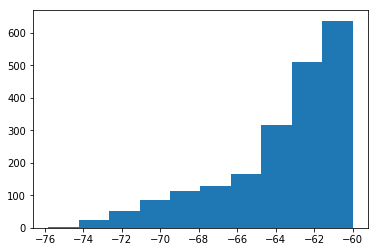

In [38]:
plt.hist(msg_img[msg_img<-60])

In [39]:
bloblist = []
tirlist = []
lat = ar_msg.lat
lon = ar_msg.lon

tir = ar_msg['tir']
tir = tir[(tir['time.hour']>=15)&(tir['time.hour']<=20)]
for day in tir[100:600]:
    date = day.time
    day.values = day/100
    img, nogood = filter_img(day.values)
    power = util.waveletT(img, dataset='METEOSAT5K_vera')
    power_msg = find_scales_dominant(power, img, no_good=nogood, core_min=-50, dataset='msg')
    
    bloblist.append(xr.DataArray(power_msg.astype(np.int16), coords={'time': date, 'lat': lat, 'lon':lon}, dims=['lat', 'lon'])) #[np.newaxis, :])
    tirlist.append(xr.DataArray(day.values, coords={'time': date, 'lat': lat, 'lon':lon}, dims=['lat', 'lon']))

ds = xr.Dataset()
ds['blobs'] = xr.concat(bloblist, 'time')
ds['tir'] = xr.concat(tirlist, 'time')

outmin -83.93 34.96
outmin -83.75 33.0
outmin -85.16 31.33
outmin -87.91 30.54
outmin -87.18 29.81
outmin -84.97 29.0
outmin -84.39 29.0
outmin -85.05 28.35
outmin -86.04 49.88
outmin -87.54 47.4
outmin -85.78 44.95
outmin -88.23 41.72
outmin -87.18 38.71
outmin -87.13 35.72
outmin -88.22 33.48
outmin -87.38 32.0
outmin -89.18 31.0
outmin -87.66 30.89
outmin -87.74 30.45
outmin -88.9 29.45
outmin -80.43 48.0
outmin -82.0 46.0
outmin -81.86 44.0
outmin -87.69 41.45
outmin -85.07 39.0
outmin -89.43 36.54
outmin -85.18 34.0
outmin -82.82 32.41
outmin -83.2 31.41
outmin -83.35 30.41
outmin -83.01 29.96
outmin -86.47 29.96
outmin -87.39 44.0
outmin -84.35 43.0
outmin -84.19 42.0
outmin -88.0 40.0
outmin -86.9 38.0
outmin -86.29 36.83
outmin -88.15 34.0
outmin -88.37 32.48
outmin -84.39 32.0
outmin -84.94 31.0
outmin -88.36 31.0
outmin -85.38 30.0
outmin -83.92 49.16
outmin -86.34 46.16
outmin -84.36 43.34
outmin -86.38 39.84
outmin -85.65 36.84
outmin -86.61 34.0
outmin -87.92 32.0
outmin -

In [2108]:
bloblist = []
tirlist = []
lat = ar_mfg.lat
lon = ar_mfg.lon

tir = ar_mfg['tir']
tir = tir[(tir['time.hour']>=15)&(tir['time.hour']<=20)]
for day in tir[100:600]:
    date = day.time
    day.values = day/100
    if np.sum(day.values) == 0:
        continue
    img, nogood = filter_img(day.values)
    power = util.waveletT(img, dataset='METEOSAT5K_vera')
   
    power_mfg = find_scales_dominant(power, img, no_good=nogood, core_min=-50, dataset='mfg')
    
    bloblist.append(xr.DataArray(power_mfg.astype(np.int16), coords={'time': date, 'lat': lat, 'lon':lon}, dims=['lat', 'lon'])) #[np.newaxis, :])
    tirlist.append(xr.DataArray(day.values, coords={'time': date, 'lat': lat, 'lon':lon}, dims=['lat', 'lon']))

ds_mfg = xr.Dataset()
ds_mfg['blobs'] = xr.concat(bloblist, 'time')
ds_mfg['tir'] = xr.concat(tirlist, 'time')

outmin -78.58 60.2
outmin -83.13 22.0
outmin -84.0 21.98
outmin -84.0 22.0
outmin -80.82 21.89
outmin -81.0 21.62
outmin -79.69 22.0
outmin -80.24 22.55
outmin -79.0 24.0
outmin -81.0 27.55
outmin -78.92 31.53
outmin -78.99 34.53
outmin -78.79 37.0
outmin -77.0 39.34
outmin -76.51 42.09
outmin -73.17 44.96
outmin -68.85 48.5
outmin -70.0 49.96
outmin -70.92 51.0
outmin -70.86 51.53
outmin -69.0 51.53
outmin -71.37 50.51
outmin -73.55 49.0
outmin -77.13 48.0
outmin -76.22 46.0
outmin -78.12 44.0
outmin -77.0 41.51
outmin -74.79 39.0
outmin -78.33 36.73
outmin -80.43 33.96
outmin -77.4 31.89
outmin -82.14 29.96
outmin -80.99 28.89
outmin -81.96 28.0
outmin -81.83 27.0
outmin -82.6 26.96
outmin -81.0 26.39
outmin -80.51 26.0
outmin -81.0 25.51
outmin -80.22 25.0
outmin -78.98 25.53
outmin -80.18 25.0
outmin -81.9 25.0
outmin -73.47 25.0
outmin -76.26 25.0
outmin -74.14 24.89
outmin -74.88 23.5
outmin -76.85 23.0
outmin -77.0 23.0
outmin -77.0 22.89
outmin -76.0 22.96
outmin -77.0 22.46
ou

outmin -82.96 30.0
outmin -80.81 30.0
outmin -80.77 29.0
outmin -81.0 28.53
outmin -81.51 28.0
outmin -81.0 28.0
outmin -81.0 28.0
outmin -81.77 26.7
outmin -83.0 26.0
outmin -80.74 24.0
outmin -79.0 24.0
outmin -79.0 24.33
outmin -74.0 23.0
outmin -79.34 23.0
outmin -79.88 23.0
outmin -77.91 23.0
outmin -77.21 22.0
outmin -77.46 22.0
outmin -78.13 22.0
outmin -80.0 22.0
outmin -78.0 24.0
outmin -80.0 26.87
outmin -80.0 29.97
outmin -79.17 32.74
outmin -79.73 36.0
outmin -77.74 56.66
outmin -73.93 41.88
outmin -75.7 45.0
outmin -73.98 47.94
outmin -74.4 49.76
outmin -74.16 50.76


In [2109]:
ds

<xarray.Dataset>
Dimensions:  (lat: 296, lon: 674, time: 500)
Coordinates:
  * lon      (lon) float64 -17.68 -17.64 -17.59 -17.55 ... 12.45 12.5 12.54
  * lat      (lat) float64 3.912 3.957 4.003 4.048 ... 16.87 16.91 16.95 17.0
  * time     (time) datetime64[ns] 2004-09-03T02:00:00 ... 2004-09-13T11:30:00
Data variables:
    blobs    (time, lat, lon) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    tir      (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 37.49 37.25 34.58

In [2110]:
ds_mfg

<xarray.Dataset>
Dimensions:  (lat: 296, lon: 674, time: 462)
Coordinates:
  * lon      (lon) float64 -17.68 -17.64 -17.59 -17.55 ... 12.45 12.5 12.54
  * lat      (lat) float64 3.912 3.957 4.003 4.048 ... 16.87 16.91 16.95 17.0
  * time     (time) datetime64[ns] 2004-09-03T02:00:00 ... 2004-09-13T11:30:00
Data variables:
    blobs    (time, lat, lon) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    tir      (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 35.03 33.88 31.82

In [2111]:
inter = np.intersect1d(ds.time,ds_mfg.time, return_indices=True)

In [2112]:
ds_msg = ds.isel(time=inter[1])
ds_msg

<xarray.Dataset>
Dimensions:  (lat: 296, lon: 674, time: 462)
Coordinates:
  * lon      (lon) float64 -17.68 -17.64 -17.59 -17.55 ... 12.45 12.5 12.54
  * lat      (lat) float64 3.912 3.957 4.003 4.048 ... 16.87 16.91 16.95 17.0
  * time     (time) datetime64[ns] 2004-09-03T02:00:00 ... 2004-09-13T11:30:00
Data variables:
    blobs    (time, lat, lon) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    tir      (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 37.49 37.25 34.58

In [2113]:
msg_blobs = ds_msg['blobs'].sel(lat=slice(5,10), lon=slice(-12,10))
mfg_blobs = ds_mfg['blobs'].sel(lat=slice(5,10), lon=slice(-12,10))
msg_tir = ds_msg['tir'].sel(lat=slice(5,10), lon=slice(-12,10))
mfg_tir = ds_mfg['tir'].sel(lat=slice(5,10), lon=slice(-12,10))

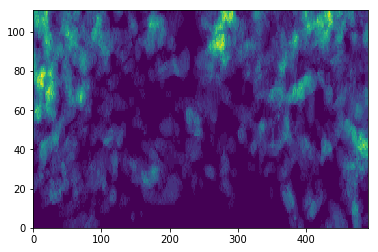

In [2114]:
plt.pcolormesh(np.sum(msg_blobs>0, axis=0).astype(int))

In [1]:
plt.pcolormesh(((np.sum(msg_blobs>0, axis=0).astype(int)-np.sum(mfg_blobs>0, axis=0).astype(int))/np.sum(msg_blobs>0, axis=0).astype(int))*100, cmap='RdBu', vmin=-50,vmax=50)
plt.colorbar()

NameError: name 'msg_blobs' is not defined

In [2116]:
np.sum((np.sum(msg_blobs>0).astype(int)-np.sum(mfg_blobs>0).astype(int)))/np.sum(mfg_blobs>0).astype(int)

<xarray.DataArray 'blobs' ()>
array(-0.004549)

(array([1.11397e+05, 3.17980e+04, 1.12420e+04, 4.02400e+03, 1.56300e+03,
        5.54000e+02, 2.04000e+02, 7.10000e+01, 5.00000e+01, 1.10000e+01]),
 array([ 12. ,  37.3,  62.6,  87.9, 113.2, 138.5, 163.8, 189.1, 214.4,
        239.7, 265. ]),
 <a list of 10 Patch objects>)

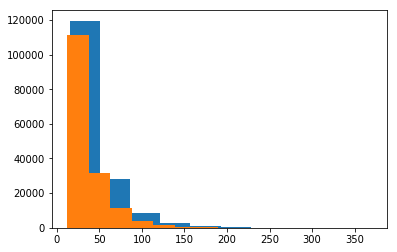

In [2117]:
plt.hist(msg_blobs.values.flat[msg_blobs.values.flat>0])
plt.hist(mfg_blobs.values.flat[mfg_blobs.values.flat>0])

In [2118]:
print('Single point')
np.sum((np.sum(msg_blobs==-999).astype(int)-np.sum(mfg_blobs==-999).astype(int)))/np.sum(mfg_blobs==-999).astype(int)

Single point


<xarray.DataArray 'blobs' ()>
array(0.075684)

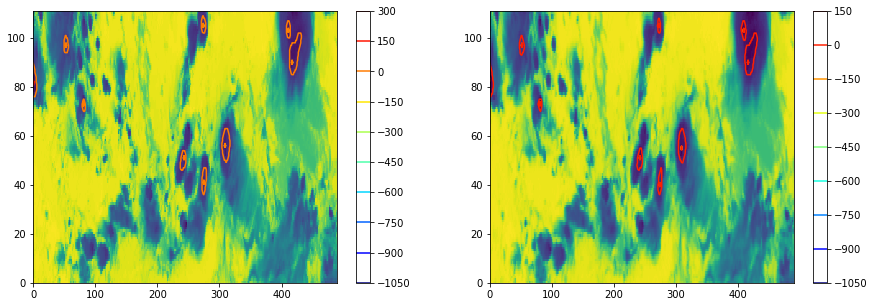

In [2043]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

levels = np.linspace(-3,3,9) #MaxNLocator(nbins=15).tick_values(z.min(), z.max())

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

index = 33

f = plt.figure(figsize=(15,5))

ax = f.add_subplot(121)
plt.pcolormesh(msg_tir[index,:,:])
plt.contour(msg_blobs[index,:,:], cmap='jet')
plt.colorbar()
ax = f.add_subplot(122)
plt.pcolormesh(mfg_tir[index,:,:])
plt.contour(mfg_blobs[index,:,:], cmap='jet')
plt.colorbar()

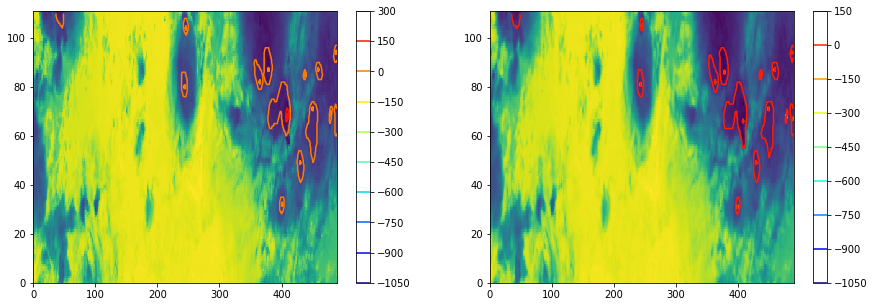

In [2119]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

levels = np.linspace(-3,3,9) #MaxNLocator(nbins=15).tick_values(z.min(), z.max())

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

index = 350

f = plt.figure(figsize=(15,5))

ax = f.add_subplot(121)
plt.pcolormesh(msg_tir[index,:,:])
plt.contour(msg_blobs[index,:,:], cmap='jet')
plt.colorbar()
ax = f.add_subplot(122)
plt.pcolormesh(mfg_tir[index,:,:])
plt.contour(mfg_blobs[index,:,:],cmap='jet')

plt.colorbar()

In [2120]:
mfg_blobs.shape

(462, 111, 490)

In [2121]:
mfg_b = np.sum(mfg_blobs<0, axis=(1,2))
msg_b = np.sum(msg_blobs<0, axis=(1,2))

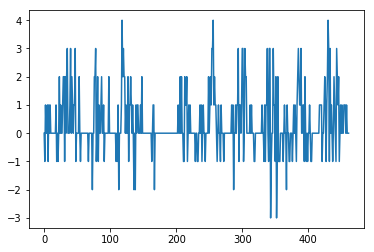

In [2122]:
plt.plot(msg_b-mfg_b)

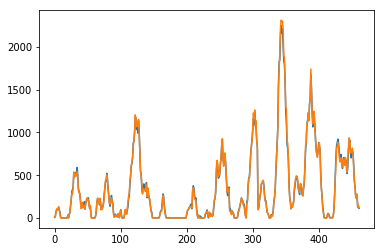

In [2123]:
mfg_b = np.sum(mfg_blobs>0, axis=(1,2))
msg_b = np.sum(msg_blobs>0, axis=(1,2))
plt.plot(msg_b)
plt.plot(mfg_b)

In [2]:
mfg_b = np.sum(mfg_blobs>0, axis=(1,2))
msg_b = np.sum(msg_blobs>0, axis=(1,2))
plt.plot(msg_b-mfg_b)
plt.ylim(-60,60)

NameError: name 'mfg_blobs' is not defined

In [2125]:
print('area', (np.sum((msg_blobs>0).astype(int))-np.sum((mfg_blobs>0).astype(int)))/np.sum((mfg_blobs>0).astype(int)))
print('points', (np.sum((msg_blobs<0).astype(int))-np.sum((mfg_blobs<0).astype(int)))/np.sum((mfg_blobs<0).astype(int)))

area <xarray.DataArray 'blobs' ()>
array(-0.004549)
points <xarray.DataArray 'blobs' ()>
array(0.075684)
